In [ ]:
!pip install transformers torch datasets tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install imbalanced_learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch, codecs, random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from datasets import load_metric
from google.colab import output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from collections import Counter
from imblearn.over_sampling import SMOTE
output.enable_custom_widget_manager()

In [ ]:
assert torch.cuda.is_available()
total_memory = torch.cuda.get_device_properties(0).total_memory
print(total_memory)
print(torch.cuda.get_device_properties('cuda:0'))

15843721216
_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
from google.colab import drive 
import sys

drive.mount('/content/drive', force_remount=True) 

## This is the file path for TAs. Students will have to make a copy and then put in the file path themselves.
colab_path="/content/drive/MyDrive/2470final/"
sys.path.append(colab_path)

dataset1  = pd.read_csv(f"{colab_path}/mbti.csv")
dataset2 = pd.read_csv(f"{colab_path}/MBTI_500.csv")
dataset = pd.concat([dataset1, dataset2])

Mounted at /content/drive


In [ ]:
dataset.describe

<bound method NDFrame.describe of         type                                              posts
0       INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1       ENTP  'I'm finding the lack of me in these posts ver...
2       INTP  'Good one  _____   https://www.youtube.com/wat...
3       INTJ  'Dear INTP,   I enjoyed our conversation the o...
4       ENTJ  'You're fired.|||That's another silly misconce...
...      ...                                                ...
106062  INFP  stay frustrate world life want take long nap w...
106063  INFP  fizzle around time mention sure mistake thing ...
106064  INFP  schedule modify hey w intp strong wing underst...
106065  INFP  enfj since january busy schedule able spend li...
106066  INFP  feel like men good problem tell parent want te...

[114742 rows x 2 columns]>

## Data Preprocessing

In [ ]:
dataset.groupby('type').count()

,posts
type,
ENFJ,1724
ENFP,6842
ENTJ,3186
ENTP,12410
ESFJ,223
ESFP,408
ESTJ,521
ESTP,2075
INFJ,16433


In [ ]:
dataset = dataset.groupby('type').head(1500)

In [ ]:
# cap data of each mbti type to 8000
dataset.groupby('type').count()

,posts
type,
ENFJ,1500
ENFP,1500
ENTJ,1500
ENTP,1500
ESFJ,223
ESFP,408
ESTJ,521
ESTP,1500
INFJ,1500


In [ ]:
dataset.values.shape

(19562, 2)

In [ ]:
X, y = dataset['posts'], dataset['type']
# lowercase
X = X.str.lower()
# replace urls
X = X.replace(regex=r'https?://[^\s<>"]+|www\.[^\s<>"]+', value = ' ')
# replace symbols
X = X.replace(regex=r'[^0-9a-z]', value=' ')
# remove extra whitespaces
X = X.str.split()
X = X.str.join(' ')
X

0        and intj moments sportscenter not top ten play...
1        i m finding the lack of me in these posts very...
2        good one course to which i say i know that s m...
3        dear intp i enjoyed our conversation the other...
4        you re fired that s another silly misconceptio...
                               ...                        
78995    blame also get feed wallow self pity selfish b...
78996    stand le care try argue pro con whatnot likely...
78997    plot line lately several play yet need friend ...
78998    exact problem problem highly extroverted use s...
78999    island see someone else call help take bridge ...
Name: posts, Length: 19562, dtype: object

In [ ]:
mbti_types = ['ISTJ','ISFJ','INFJ','INTJ','ISTP','ISFP','INFP','INTP','ESTP','ESFP','ENFP','ENTP','ESTJ','ESFJ','ENFJ','ENTJ']
labels_map = dict(zip(mbti_types, range(16)))
labels_map

{'ISTJ': 0,
 'ISFJ': 1,
 'INFJ': 2,
 'INTJ': 3,
 'ISTP': 4,
 'ISFP': 5,
 'INFP': 6,
 'INTP': 7,
 'ESTP': 8,
 'ESFP': 9,
 'ENFP': 10,
 'ENTP': 11,
 'ESTJ': 12,
 'ESFJ': 13,
 'ENFJ': 14,
 'ENTJ': 15}

In [ ]:
y = y.replace(labels_map)
y

0         2
1        11
2         7
3         3
4        15
         ..
78995     2
78996     2
78997     2
78998     2
78999     2
Name: type, Length: 19562, dtype: int64

In [ ]:
X, y = X.tolist(), y.tolist()
len(X), len(y)

(19562, 19562)

## Training

In [ ]:
class PostDataset(torch.utils.data.Dataset):

  def __init__(self, posts, mbtis, tokenizer):

    self.posts = posts
    self.mbtis = mbtis
    self.tokenizer = tokenizer
    self.max_len = tokenizer.model_max_length

  def __len__(self):

    return len(self.posts)

  def __getitem__(self, index):

    post = str(self.posts[index])
    mbti = self.mbtis[index]

    encoded_post = self.tokenizer.encode_plus(
      post,
      add_special_tokens      = True,
      max_length              = self.max_len,
      return_token_type_ids   = False,
      return_attention_mask   = True,
      return_tensors          = "pt",
      padding                 = "max_length",
      truncation              = True
    )

    return {
      'input_ids': encoded_post['input_ids'][0],
      'attention_mask': encoded_post['attention_mask'][0],
      'labels': torch.tensor(mbti, dtype=torch.long)
    }

In [ ]:
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
# use this for the tokenizer argument of the PostDataset
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# define the following dataset objects... split into 80-10-10 for training, validation, and test data
X_train, X_temp,  y_train, y_temp = train_test_split(X, y, test_size = 0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state=42)
train_dataset = PostDataset(X_train,y_train,tokenizer)
validation_dataset = PostDataset(X_valid,y_valid,tokenizer)
test_dataset = PostDataset(X_test,y_test,tokenizer)

# now construct DataLoader objects from the TweetDataset objects
# remember that the TweetDataset class is a child class of torch.utils.data.Dataset
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
from transformers import AutoModelForSequenceClassification # no need for AutoConfig

pretrained_model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=16)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

In [ ]:
#this cell is almost same as the stencil code above
def update_metrics(metrics, predictions, labels):
  """ Update a list of metrics with new predictions and labels
  
  :param list<datasets.Metric> metrics: list of metrics
  :param torch.Tensor predictions: tensor of predictions of shape (1, batch_size)
  :param torch.Tensor labels: tensor of labels of shape (1, batch_size)

  :return None
  """
  # Nothing TODO here! This updates metrics based on a batch of predictions
  # and a batch of labels.
  for metric in metrics:
    metric.add_batch(predictions=predictions, references=labels)

def evaluate(model, test_dataloader, device, metric_strs):
  """ Evaluate a PyTorch Model
  
  :param torch.nn.Module model: the model to be evaluated
  :param torch.utils.data.DataLoader test_dataloader: DataLoader containing testing examples
  :param torch.device device: the device that we'll be training on
  :param list<string> metric_strs: the names of Hugging Face metrics to use

  :return dictionary<string, float>: dictionary of metrics names mapped to their values
  """
  # load metrics
  metrics = [load_metric(x) for x in metric_strs] # could add more here!
  model.eval()

  # we like progress bars :)
  progress_bar = tqdm(range(len(test_dataloader)))

  for batch in test_dataloader:
    inputs={}
    inputs['input_ids']=batch['input_ids'].to(device)
    inputs['labels']=batch['labels'].to(device)
    inputs['attention_mask']=batch['attention_mask'].to(device)
    with torch.no_grad():
      logits = model(**inputs).logits
    preds = torch.argmax(logits, dim=1)
    update_metrics(metrics,preds,batch['labels'])

    progress_bar.update(1)
    
  # compute and return metrics
  computed = {}
  for m in metrics:
    computed = {**computed, **m.compute()}

  return computed

In [ ]:
#this cell is almost same as the stencil code above
from scipy.stats import describe
from math import sqrt

def make_plots(perfs, names):
  for perf, name in zip(perfs, names):
    print(f"{name} accuracy: {perf}")
  plt.bar(np.arange(len(perfs)), perfs)
  plt.xticks(np.arange(len(names)), names)
  plt.show()

<ipython-input-18-c957031d2c1a>:27: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metrics = [load_metric(x) for x in metric_strs] # could add more here!


  0%|          | 0/62 [00:00<?, ?it/s]

Pretrained result accuracy: 0.1205927439959121


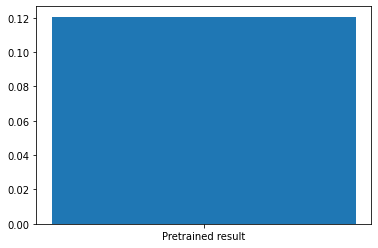

In [ ]:
#this cell is almost same as the stencil code above
# This gives us a way to use the GPU to run models! 
# For any parameter named 'device', pass the following variable:
torch.cuda.empty_cache()
device = torch.device("cuda")
pretrained_model.to(device)
metrics = ['accuracy']
pretrained_result = evaluate(pretrained_model, test_dataloader, device, metrics)['accuracy']

results = [pretrained_result]
names = ['Pretrained result']
make_plots(results, names)

In [ ]:
#this cell is almost same as the stencil code above
from datasets import load_metric

def train(model, optimizer, num_epochs, train_dataloader, validation_dataloader, lr_scheduler, device):
  """ Train a PyTorch Module
  
  :param torch.nn.Module model: the model to be trained
  :param torch.optim.Optimizer optimizer: the training optimizer
  :param int num_epochs: number of epochs to train for
  :param torch.utils.data.DataLoader train_dataloader: DataLoader containing training examples
  :param torch.utils.data.DataLoader validation_dataloader: DataLoader containing validation examples
  :param _ lr_scheduler: learning rate scheduler
  :param torch.device device: the device that we'll be training on
  
  :return None
  """

  for epoch in range(num_epochs):
    # put the model in training mode (important that this is done each epoch,
    # since we put the model into eval mode during validation)
    model.train()

    # load metrics
    metrics = [load_metric(x) for x in ["accuracy"]] # could add more here!

    print(f"Epoch {epoch + 1} training:")
    progress_bar = tqdm(range(len(train_dataloader)))

    for i, batch in enumerate(train_dataloader):
      inputs={}
      inputs['input_ids']=batch['input_ids'].to(device)
      inputs['labels']=batch['labels'].to(device)
      inputs['attention_mask']=batch['attention_mask'].to(device)
      output = model(**inputs)
      logits=output.logits
      preds = torch.argmax(logits, dim=1)
      loss=output.loss
      loss.backward()
      optimizer.step()
      update_metrics(metrics,preds,batch['labels'])
      progress_bar.update(1)
      optimizer.zero_grad()
      lr_scheduler.step()
    print(f"Epoch {epoch+1} average training metrics: accuracy={metrics[0].compute()['accuracy']}")
    print("Running validation:")
    val_metrics =  evaluate(model, validation_dataloader, device, ['accuracy'])
    print(f"Epoch {epoch+1} validation: accuracy={val_metrics['accuracy']}")

In [ ]:
#this cell is almost same as the stencil code above
from transformers import get_scheduler
# fine-tuning pre-trained model(cross-encoder/nli-distilroberta-base):
num_epochs = 5

# use the same kind of optimizer as before, but with the pretrained model's parameters
optimizer = torch.optim.AdamW(pretrained_model.parameters(), lr=5e-5, betas=(0.9, 0.999),
                              eps=1e-08, weight_decay=0.01, amsgrad=False, maximize=False, foreach=None, capturable=False)

# this hasn't changed
lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=50,
  num_training_steps=len(train_dataloader) * num_epochs
)

In [ ]:
torch.cuda.empty_cache()
pretrained_model.to(device)

train(pretrained_model, optimizer, num_epochs, train_dataloader, validation_dataloader, lr_scheduler, device)

Epoch 1 training:


  0%|          | 0/490 [00:00<?, ?it/s]

Epoch 1 average training metrics: accuracy=0.4935139625535178
Running validation:


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch 1 validation: accuracy=0.6932515337423313
Epoch 2 training:


  0%|          | 0/490 [00:00<?, ?it/s]

Epoch 2 average training metrics: accuracy=0.7259249792318998
Running validation:


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch 2 validation: accuracy=0.7249488752556237
Epoch 3 training:


  0%|          | 0/490 [00:00<?, ?it/s]

Epoch 3 average training metrics: accuracy=0.7960892069780817
Running validation:


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch 3 validation: accuracy=0.7530674846625767
Epoch 4 training:


  0%|          | 0/490 [00:00<?, ?it/s]

Epoch 4 average training metrics: accuracy=0.8528340469039555
Running validation:


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch 4 validation: accuracy=0.7443762781186094
Epoch 5 training:


  0%|          | 0/490 [00:00<?, ?it/s]

Epoch 5 average training metrics: accuracy=0.8994184931944533
Running validation:


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch 5 validation: accuracy=0.7474437627811861


  0%|          | 0/62 [00:00<?, ?it/s]

Pre-trained accuracy: 0.1205927439959121
Fine-tuned accuracy: 0.7542156361778232


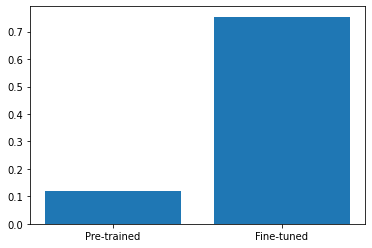

In [ ]:
# Evaluate the fine-tuned model(cross-encoder/nli-distilroberta-base) on the test dataset
finetuned_result = evaluate(pretrained_model, test_dataloader, device, ['accuracy'])['accuracy']

# now, plot!
results = [pretrained_result, finetuned_result]
names = ['Pre-trained', 'Fine-tuned']
make_plots(results, names)

In [ ]:
# save model
torch.save(pretrained_model, '/content/drive/MyDrive/2470final/mbti_bert.pt')